In [2]:
# === 1. Imports y configuración ===
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import joblib

from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.model_selection import StratifiedKFold, train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import f1_score, classification_report, confusion_matrix, roc_auc_score, roc_curve
from imblearn.over_sampling import SMOTE
from lightgbm import LGBMClassifier
import optuna


In [3]:
# === 2. Clase de preprocesamiento personalizado ===
class CustomPreprocessor(BaseEstimator, TransformerMixin):
    def __init__(self):
        self.label_encoders = {}

    def fit(self, X, y=None):
        for col in X.select_dtypes(include='object').columns:
            le = LabelEncoder()
            le.fit(X[col])
            self.label_encoders[col] = le
        return self

    def transform(self, X):
        X = X.copy()
        if 'ProductRelated_Duration' in X.columns:
            X['ProductRelated_Duration'] = np.log1p(X['ProductRelated_Duration'])
        for col, le in self.label_encoders.items():
            X[col] = le.transform(X[col])
        return X


In [4]:
# === 3. Rutas y carga de datos ===
def get_project_root(levels=1):
    path = os.getcwd()
    for _ in range(levels):
        path = os.path.dirname(path)
    return path

# Cambia el número de niveles según tu estructura
project_root = get_project_root(levels=3)
print(f"Project root: {project_root}")
data_dir = os.path.join(project_root, "data")
data_dir = os.path.join(data_dir, "clean")
clean_csv_path = os.path.join(data_dir, "online_shoppers_clean.csv")
print(f"Data directory: {data_dir}")
print(f"Clean CSV path: {clean_csv_path}")
df = pd.read_csv(clean_csv_path)


Project root: c:\Users\Fernando\VSC\python\dev\Proyecto-Clasificaci-n_grupo6
Data directory: c:\Users\Fernando\VSC\python\dev\Proyecto-Clasificaci-n_grupo6\data\clean
Clean CSV path: c:\Users\Fernando\VSC\python\dev\Proyecto-Clasificaci-n_grupo6\data\clean\online_shoppers_clean.csv


In [5]:
# === 4. Preprocesamiento ===
preprocessor = CustomPreprocessor()
X = preprocessor.fit_transform(df.drop("Revenue", axis=1))
y = df["Revenue"].astype(int)

# Guardar el preprocesador
joblib.dump(preprocessor, "lightgbm_preprocessor.pkl")
print("Preprocesador guardado como 'preprocessor.pkl'")

X = pd.DataFrame(X, columns=df.drop("Revenue", axis=1).columns)

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)


Preprocesador guardado como 'preprocessor.pkl'


In [6]:
# === 5. Optuna: búsqueda de hiperparámetros ===
def objective(trial):
    params = {
        "n_estimators": 500,
        "learning_rate": trial.suggest_float("learning_rate", 0.01, 0.2, log=True),
        "max_depth": trial.suggest_int("max_depth", 3, 10),
        "num_leaves": trial.suggest_int("num_leaves", 20, 150),
        "min_child_samples": trial.suggest_int("min_child_samples", 5, 100),
        "subsample": trial.suggest_float("subsample", 0.5, 1.0),
        "colsample_bytree": trial.suggest_float("colsample_bytree", 0.5, 1.0),
        "class_weight": "balanced",
        "random_state": 42
    }
    params["lambda_l1"] = trial.suggest_float("lambda_l1", 1e-3, 10.0, log=True)
    params["lambda_l2"] = trial.suggest_float("lambda_l2", 1e-3, 10.0, log=True)
    params["min_child_samples"] = trial.suggest_int("min_child_samples", 20, 100)


    skf = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)
    f1_scores = []

    for train_idx, val_idx in skf.split(X_train, y_train):
        X_tr, X_val = X_train.iloc[train_idx], X_train.iloc[val_idx]
        y_tr, y_val = y_train.iloc[train_idx], y_train.iloc[val_idx]

        smote = SMOTE(random_state=42)
        X_res, y_res = smote.fit_resample(X_tr, y_tr)

        model = LGBMClassifier(**params)
        model.fit(X_res, y_res)

        y_val_proba = model.predict_proba(X_val)[:, 1]

        best_f1 = 0
        for t in np.linspace(0.3, 0.7, 15):
            y_val_pred = (y_val_proba > t).astype(int)
            f1 = f1_score(y_val, y_val_pred)
            best_f1 = max(best_f1, f1)

        f1_scores.append(best_f1)

    return np.mean(f1_scores)

study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=30)


[I 2025-05-08 14:41:49,775] A new study created in memory with name: no-name-9b56cb00-3797-4a27-a422-6e06bd19ed93
c:\Users\Fernando\VSC\python\dev\Proyecto-Clasificaci-n_grupo6\.venv\Lib\site-packages\optuna\trial\_trial.py:678: RuntimeWarning: Inconsistent parameter values for distribution with name "min_child_samples"! This might be a configuration mistake. Optuna allows to call the same distribution with the same name more than once in a trial. When the parameter values are inconsistent optuna only uses the values of the first call and ignores all following. Using these values: {'log': False, 'step': 1, 'low': 5, 'high': 100}
  warnings.warn(


[LightGBM] [Warning] lambda_l1 is set=0.00723821898304958, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.00723821898304958
[LightGBM] [Warning] lambda_l2 is set=3.0648135398662966, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.0648135398662966
[LightGBM] [Warning] lambda_l1 is set=0.00723821898304958, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.00723821898304958
[LightGBM] [Warning] lambda_l2 is set=3.0648135398662966, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.0648135398662966
[LightGBM] [Info] Number of positive: 5492, number of negative: 5492
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.014531 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2147
[LightGBM] [Info] Number of data points in the train set: 10984, number of used features: 17
[LightGBM] [Info] [binary:BoostFromScore

[I 2025-05-08 14:42:08,623] Trial 0 finished with value: 0.6651169867885068 and parameters: {'learning_rate': 0.1241699117854793, 'max_depth': 3, 'num_leaves': 60, 'min_child_samples': 86, 'subsample': 0.8675423293183062, 'colsample_bytree': 0.5358502431594955, 'lambda_l1': 0.00723821898304958, 'lambda_l2': 3.0648135398662966}. Best is trial 0 with value: 0.6651169867885068.
c:\Users\Fernando\VSC\python\dev\Proyecto-Clasificaci-n_grupo6\.venv\Lib\site-packages\optuna\trial\_trial.py:678: RuntimeWarning: Inconsistent parameter values for distribution with name "min_child_samples"! This might be a configuration mistake. Optuna allows to call the same distribution with the same name more than once in a trial. When the parameter values are inconsistent optuna only uses the values of the first call and ignores all following. Using these values: {'log': False, 'step': 1, 'low': 5, 'high': 100}
  warnings.warn(


[LightGBM] [Warning] lambda_l1 is set=0.045273967916794715, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.045273967916794715
[LightGBM] [Warning] lambda_l2 is set=0.23682971382613419, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.23682971382613419
[LightGBM] [Warning] lambda_l1 is set=0.045273967916794715, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.045273967916794715
[LightGBM] [Warning] lambda_l2 is set=0.23682971382613419, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.23682971382613419
[LightGBM] [Info] Number of positive: 5492, number of negative: 5492
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.011117 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2147
[LightGBM] [Info] Number of data points in the train set: 10984, number of used features: 17
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Warni

[I 2025-05-08 14:42:38,031] Trial 1 finished with value: 0.6688737738539418 and parameters: {'learning_rate': 0.01600038887441711, 'max_depth': 8, 'num_leaves': 104, 'min_child_samples': 6, 'subsample': 0.5175856071467921, 'colsample_bytree': 0.784898128431524, 'lambda_l1': 0.045273967916794715, 'lambda_l2': 0.23682971382613419}. Best is trial 1 with value: 0.6688737738539418.
c:\Users\Fernando\VSC\python\dev\Proyecto-Clasificaci-n_grupo6\.venv\Lib\site-packages\optuna\trial\_trial.py:678: RuntimeWarning: Inconsistent parameter values for distribution with name "min_child_samples"! This might be a configuration mistake. Optuna allows to call the same distribution with the same name more than once in a trial. When the parameter values are inconsistent optuna only uses the values of the first call and ignores all following. Using these values: {'log': False, 'step': 1, 'low': 5, 'high': 100}
  warnings.warn(


[LightGBM] [Warning] lambda_l1 is set=0.18130803006173607, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.18130803006173607
[LightGBM] [Warning] lambda_l2 is set=0.009578907686366496, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.009578907686366496
[LightGBM] [Warning] lambda_l1 is set=0.18130803006173607, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.18130803006173607
[LightGBM] [Warning] lambda_l2 is set=0.009578907686366496, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.009578907686366496
[LightGBM] [Info] Number of positive: 5492, number of negative: 5492
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005009 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2147
[LightGBM] [Info] Number of data points in the train set: 10984, number of used features: 17
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Warni

[I 2025-05-08 14:43:24,979] Trial 2 finished with value: 0.6690642818648361 and parameters: {'learning_rate': 0.012787597414834236, 'max_depth': 10, 'num_leaves': 85, 'min_child_samples': 56, 'subsample': 0.5525305798789535, 'colsample_bytree': 0.6232588288204228, 'lambda_l1': 0.18130803006173607, 'lambda_l2': 0.009578907686366496}. Best is trial 2 with value: 0.6690642818648361.
c:\Users\Fernando\VSC\python\dev\Proyecto-Clasificaci-n_grupo6\.venv\Lib\site-packages\optuna\trial\_trial.py:678: RuntimeWarning: Inconsistent parameter values for distribution with name "min_child_samples"! This might be a configuration mistake. Optuna allows to call the same distribution with the same name more than once in a trial. When the parameter values are inconsistent optuna only uses the values of the first call and ignores all following. Using these values: {'log': False, 'step': 1, 'low': 5, 'high': 100}
  warnings.warn(


[LightGBM] [Warning] lambda_l1 is set=0.005109809774601644, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.005109809774601644
[LightGBM] [Warning] lambda_l2 is set=0.5004884643134971, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.5004884643134971
[LightGBM] [Warning] lambda_l1 is set=0.005109809774601644, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.005109809774601644
[LightGBM] [Warning] lambda_l2 is set=0.5004884643134971, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.5004884643134971
[LightGBM] [Info] Number of positive: 5492, number of negative: 5492
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.006285 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2147
[LightGBM] [Info] Number of data points in the train set: 10984, number of used features: 17
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Warning] 

[I 2025-05-08 14:44:37,929] Trial 3 finished with value: 0.6565742513584089 and parameters: {'learning_rate': 0.03987010112957441, 'max_depth': 8, 'num_leaves': 72, 'min_child_samples': 56, 'subsample': 0.9624289392450895, 'colsample_bytree': 0.8158692706516488, 'lambda_l1': 0.005109809774601644, 'lambda_l2': 0.5004884643134971}. Best is trial 2 with value: 0.6690642818648361.
c:\Users\Fernando\VSC\python\dev\Proyecto-Clasificaci-n_grupo6\.venv\Lib\site-packages\optuna\trial\_trial.py:678: RuntimeWarning: Inconsistent parameter values for distribution with name "min_child_samples"! This might be a configuration mistake. Optuna allows to call the same distribution with the same name more than once in a trial. When the parameter values are inconsistent optuna only uses the values of the first call and ignores all following. Using these values: {'log': False, 'step': 1, 'low': 5, 'high': 100}
  warnings.warn(


[LightGBM] [Warning] lambda_l1 is set=0.1179531237070723, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.1179531237070723
[LightGBM] [Warning] lambda_l2 is set=0.2221326720988822, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.2221326720988822
[LightGBM] [Warning] lambda_l1 is set=0.1179531237070723, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.1179531237070723
[LightGBM] [Warning] lambda_l2 is set=0.2221326720988822, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.2221326720988822
[LightGBM] [Info] Number of positive: 5492, number of negative: 5492
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004709 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2147
[LightGBM] [Info] Number of data points in the train set: 10984, number of used features: 17
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Warning] No furth

[I 2025-05-08 14:45:16,239] Trial 4 finished with value: 0.647803494188954 and parameters: {'learning_rate': 0.10176282943281208, 'max_depth': 6, 'num_leaves': 73, 'min_child_samples': 24, 'subsample': 0.9507875514373519, 'colsample_bytree': 0.8252169582043685, 'lambda_l1': 0.1179531237070723, 'lambda_l2': 0.2221326720988822}. Best is trial 2 with value: 0.6690642818648361.
c:\Users\Fernando\VSC\python\dev\Proyecto-Clasificaci-n_grupo6\.venv\Lib\site-packages\optuna\trial\_trial.py:678: RuntimeWarning: Inconsistent parameter values for distribution with name "min_child_samples"! This might be a configuration mistake. Optuna allows to call the same distribution with the same name more than once in a trial. When the parameter values are inconsistent optuna only uses the values of the first call and ignores all following. Using these values: {'log': False, 'step': 1, 'low': 5, 'high': 100}
  warnings.warn(


[LightGBM] [Warning] lambda_l1 is set=0.16607071972869072, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.16607071972869072
[LightGBM] [Warning] lambda_l2 is set=0.002006697157720305, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.002006697157720305
[LightGBM] [Warning] lambda_l1 is set=0.16607071972869072, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.16607071972869072
[LightGBM] [Warning] lambda_l2 is set=0.002006697157720305, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.002006697157720305
[LightGBM] [Info] Number of positive: 5492, number of negative: 5492
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.013686 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2147
[LightGBM] [Info] Number of data points in the train set: 10984, number of used features: 17
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Warni

[I 2025-05-08 14:45:52,070] Trial 5 finished with value: 0.6567518649581389 and parameters: {'learning_rate': 0.06622954856708496, 'max_depth': 7, 'num_leaves': 100, 'min_child_samples': 23, 'subsample': 0.6577495706751613, 'colsample_bytree': 0.798406956138288, 'lambda_l1': 0.16607071972869072, 'lambda_l2': 0.002006697157720305}. Best is trial 2 with value: 0.6690642818648361.
c:\Users\Fernando\VSC\python\dev\Proyecto-Clasificaci-n_grupo6\.venv\Lib\site-packages\optuna\trial\_trial.py:678: RuntimeWarning: Inconsistent parameter values for distribution with name "min_child_samples"! This might be a configuration mistake. Optuna allows to call the same distribution with the same name more than once in a trial. When the parameter values are inconsistent optuna only uses the values of the first call and ignores all following. Using these values: {'log': False, 'step': 1, 'low': 5, 'high': 100}
  warnings.warn(


[LightGBM] [Warning] lambda_l1 is set=0.6553977105748684, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.6553977105748684
[LightGBM] [Warning] lambda_l2 is set=9.340964672232326, reg_lambda=0.0 will be ignored. Current value: lambda_l2=9.340964672232326
[LightGBM] [Warning] lambda_l1 is set=0.6553977105748684, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.6553977105748684
[LightGBM] [Warning] lambda_l2 is set=9.340964672232326, reg_lambda=0.0 will be ignored. Current value: lambda_l2=9.340964672232326
[LightGBM] [Info] Number of positive: 5492, number of negative: 5492
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.011219 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2147
[LightGBM] [Info] Number of data points in the train set: 10984, number of used features: 17
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Warning] No further s

[I 2025-05-08 14:46:23,497] Trial 6 finished with value: 0.655767057826107 and parameters: {'learning_rate': 0.07530610879817475, 'max_depth': 9, 'num_leaves': 87, 'min_child_samples': 27, 'subsample': 0.6518348683417435, 'colsample_bytree': 0.539510692403728, 'lambda_l1': 0.6553977105748684, 'lambda_l2': 9.340964672232326}. Best is trial 2 with value: 0.6690642818648361.
c:\Users\Fernando\VSC\python\dev\Proyecto-Clasificaci-n_grupo6\.venv\Lib\site-packages\optuna\trial\_trial.py:678: RuntimeWarning: Inconsistent parameter values for distribution with name "min_child_samples"! This might be a configuration mistake. Optuna allows to call the same distribution with the same name more than once in a trial. When the parameter values are inconsistent optuna only uses the values of the first call and ignores all following. Using these values: {'log': False, 'step': 1, 'low': 5, 'high': 100}
  warnings.warn(


[LightGBM] [Warning] lambda_l1 is set=0.09932198448289345, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.09932198448289345
[LightGBM] [Warning] lambda_l2 is set=0.8826063087596985, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.8826063087596985
[LightGBM] [Warning] lambda_l1 is set=0.09932198448289345, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.09932198448289345
[LightGBM] [Warning] lambda_l2 is set=0.8826063087596985, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.8826063087596985
[LightGBM] [Info] Number of positive: 5492, number of negative: 5492
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.027606 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2147
[LightGBM] [Info] Number of data points in the train set: 10984, number of used features: 17
[LightGBM] [Info] [binary:BoostFromScore

[I 2025-05-08 14:46:56,503] Trial 7 finished with value: 0.6383153409191972 and parameters: {'learning_rate': 0.09675708495084549, 'max_depth': 10, 'num_leaves': 77, 'min_child_samples': 99, 'subsample': 0.8489054302862826, 'colsample_bytree': 0.6994206724543421, 'lambda_l1': 0.09932198448289345, 'lambda_l2': 0.8826063087596985}. Best is trial 2 with value: 0.6690642818648361.
c:\Users\Fernando\VSC\python\dev\Proyecto-Clasificaci-n_grupo6\.venv\Lib\site-packages\optuna\trial\_trial.py:678: RuntimeWarning: Inconsistent parameter values for distribution with name "min_child_samples"! This might be a configuration mistake. Optuna allows to call the same distribution with the same name more than once in a trial. When the parameter values are inconsistent optuna only uses the values of the first call and ignores all following. Using these values: {'log': False, 'step': 1, 'low': 5, 'high': 100}
  warnings.warn(


[LightGBM] [Warning] lambda_l1 is set=9.229076020481864, reg_alpha=0.0 will be ignored. Current value: lambda_l1=9.229076020481864
[LightGBM] [Warning] lambda_l2 is set=1.1985393812296714, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.1985393812296714
[LightGBM] [Warning] lambda_l1 is set=9.229076020481864, reg_alpha=0.0 will be ignored. Current value: lambda_l1=9.229076020481864
[LightGBM] [Warning] lambda_l2 is set=1.1985393812296714, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.1985393812296714
[LightGBM] [Info] Number of positive: 5492, number of negative: 5492
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003398 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2147
[LightGBM] [Info] Number of data points in the train set: 10984, number of used features: 17
[LightGBM] [Info] [binary:BoostFromScore]: pavg=

[I 2025-05-08 14:47:16,632] Trial 8 finished with value: 0.6708294289689638 and parameters: {'learning_rate': 0.10615671409235061, 'max_depth': 3, 'num_leaves': 65, 'min_child_samples': 17, 'subsample': 0.8039242415305532, 'colsample_bytree': 0.6030307185774297, 'lambda_l1': 9.229076020481864, 'lambda_l2': 1.1985393812296714}. Best is trial 8 with value: 0.6708294289689638.
c:\Users\Fernando\VSC\python\dev\Proyecto-Clasificaci-n_grupo6\.venv\Lib\site-packages\optuna\trial\_trial.py:678: RuntimeWarning: Inconsistent parameter values for distribution with name "min_child_samples"! This might be a configuration mistake. Optuna allows to call the same distribution with the same name more than once in a trial. When the parameter values are inconsistent optuna only uses the values of the first call and ignores all following. Using these values: {'log': False, 'step': 1, 'low': 5, 'high': 100}
  warnings.warn(


[LightGBM] [Warning] lambda_l1 is set=0.1278179772091601, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.1278179772091601
[LightGBM] [Warning] lambda_l2 is set=1.059249413467021, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.059249413467021
[LightGBM] [Warning] lambda_l1 is set=0.1278179772091601, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.1278179772091601
[LightGBM] [Warning] lambda_l2 is set=1.059249413467021, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.059249413467021
[LightGBM] [Info] Number of positive: 5492, number of negative: 5492
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.008962 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2147
[LightGBM] [Info] Number of data points in the train set: 10984, number of used features: 17
[LightGBM] [Info] [binary:BoostFromScore]: pavg=

[I 2025-05-08 14:48:00,096] Trial 9 finished with value: 0.6665133253749662 and parameters: {'learning_rate': 0.012890412881221254, 'max_depth': 9, 'num_leaves': 82, 'min_child_samples': 80, 'subsample': 0.6472020473512954, 'colsample_bytree': 0.7336411329053355, 'lambda_l1': 0.1278179772091601, 'lambda_l2': 1.059249413467021}. Best is trial 8 with value: 0.6708294289689638.
c:\Users\Fernando\VSC\python\dev\Proyecto-Clasificaci-n_grupo6\.venv\Lib\site-packages\optuna\trial\_trial.py:678: RuntimeWarning: Inconsistent parameter values for distribution with name "min_child_samples"! This might be a configuration mistake. Optuna allows to call the same distribution with the same name more than once in a trial. When the parameter values are inconsistent optuna only uses the values of the first call and ignores all following. Using these values: {'log': False, 'step': 1, 'low': 5, 'high': 100}
  warnings.warn(


[LightGBM] [Warning] lambda_l1 is set=6.663357419343838, reg_alpha=0.0 will be ignored. Current value: lambda_l1=6.663357419343838
[LightGBM] [Warning] lambda_l2 is set=0.03707103328485642, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.03707103328485642
[LightGBM] [Warning] lambda_l1 is set=6.663357419343838, reg_alpha=0.0 will be ignored. Current value: lambda_l1=6.663357419343838
[LightGBM] [Warning] lambda_l2 is set=0.03707103328485642, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.03707103328485642
[LightGBM] [Info] Number of positive: 5492, number of negative: 5492
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.014350 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2147
[LightGBM] [Info] Number of data points in the train set: 10984, number of used features: 17
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Warning] No furth

[I 2025-05-08 14:48:13,543] Trial 10 finished with value: 0.6745224921865923 and parameters: {'learning_rate': 0.028292909483691175, 'max_depth': 3, 'num_leaves': 24, 'min_child_samples': 40, 'subsample': 0.7988381961148984, 'colsample_bytree': 0.8945266731903847, 'lambda_l1': 6.663357419343838, 'lambda_l2': 0.03707103328485642}. Best is trial 10 with value: 0.6745224921865923.
c:\Users\Fernando\VSC\python\dev\Proyecto-Clasificaci-n_grupo6\.venv\Lib\site-packages\optuna\trial\_trial.py:678: RuntimeWarning: Inconsistent parameter values for distribution with name "min_child_samples"! This might be a configuration mistake. Optuna allows to call the same distribution with the same name more than once in a trial. When the parameter values are inconsistent optuna only uses the values of the first call and ignores all following. Using these values: {'log': False, 'step': 1, 'low': 5, 'high': 100}
  warnings.warn(


[LightGBM] [Warning] lambda_l1 is set=9.225508314484603, reg_alpha=0.0 will be ignored. Current value: lambda_l1=9.225508314484603
[LightGBM] [Warning] lambda_l2 is set=0.03900290056675983, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.03900290056675983
[LightGBM] [Warning] lambda_l1 is set=9.225508314484603, reg_alpha=0.0 will be ignored. Current value: lambda_l1=9.225508314484603
[LightGBM] [Warning] lambda_l2 is set=0.03900290056675983, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.03900290056675983
[LightGBM] [Info] Number of positive: 5492, number of negative: 5492
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001250 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2147
[LightGBM] [Info] Number of data points in the train set: 10984, number of used features: 17
[LightGBM] [Info] [binary:BoostFromScore]: p

[I 2025-05-08 14:48:26,831] Trial 11 finished with value: 0.6735097782511575 and parameters: {'learning_rate': 0.030837885104344136, 'max_depth': 3, 'num_leaves': 20, 'min_child_samples': 40, 'subsample': 0.7808732715662278, 'colsample_bytree': 0.9776267320179595, 'lambda_l1': 9.225508314484603, 'lambda_l2': 0.03900290056675983}. Best is trial 10 with value: 0.6745224921865923.
c:\Users\Fernando\VSC\python\dev\Proyecto-Clasificaci-n_grupo6\.venv\Lib\site-packages\optuna\trial\_trial.py:678: RuntimeWarning: Inconsistent parameter values for distribution with name "min_child_samples"! This might be a configuration mistake. Optuna allows to call the same distribution with the same name more than once in a trial. When the parameter values are inconsistent optuna only uses the values of the first call and ignores all following. Using these values: {'log': False, 'step': 1, 'low': 5, 'high': 100}
  warnings.warn(


[LightGBM] [Warning] lambda_l1 is set=9.478680566653292, reg_alpha=0.0 will be ignored. Current value: lambda_l1=9.478680566653292
[LightGBM] [Warning] lambda_l2 is set=0.03505884895607079, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.03505884895607079
[LightGBM] [Warning] lambda_l1 is set=9.478680566653292, reg_alpha=0.0 will be ignored. Current value: lambda_l1=9.478680566653292
[LightGBM] [Warning] lambda_l2 is set=0.03505884895607079, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.03505884895607079
[LightGBM] [Info] Number of positive: 5492, number of negative: 5492
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.091974 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2147
[LightGBM] [Info] Number of data points in the train set: 10984, number of used features: 17
[LightGBM] [Info] [binary:BoostFromScore]: p

[I 2025-05-08 14:48:44,780] Trial 12 finished with value: 0.6689632610685489 and parameters: {'learning_rate': 0.02861952262118345, 'max_depth': 5, 'num_leaves': 21, 'min_child_samples': 43, 'subsample': 0.7455489508659919, 'colsample_bytree': 0.9913791391607534, 'lambda_l1': 9.478680566653292, 'lambda_l2': 0.03505884895607079}. Best is trial 10 with value: 0.6745224921865923.
c:\Users\Fernando\VSC\python\dev\Proyecto-Clasificaci-n_grupo6\.venv\Lib\site-packages\optuna\trial\_trial.py:678: RuntimeWarning: Inconsistent parameter values for distribution with name "min_child_samples"! This might be a configuration mistake. Optuna allows to call the same distribution with the same name more than once in a trial. When the parameter values are inconsistent optuna only uses the values of the first call and ignores all following. Using these values: {'log': False, 'step': 1, 'low': 5, 'high': 100}
  warnings.warn(


[LightGBM] [Warning] lambda_l1 is set=2.0385024680228097, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.0385024680228097
[LightGBM] [Warning] lambda_l2 is set=0.042968190496098235, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.042968190496098235
[LightGBM] [Warning] lambda_l1 is set=2.0385024680228097, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.0385024680228097
[LightGBM] [Warning] lambda_l2 is set=0.042968190496098235, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.042968190496098235
[LightGBM] [Info] Number of positive: 5492, number of negative: 5492
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.094967 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2147
[LightGBM] [Info] Number of data points in the train set: 10984, number of used features: 17
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Warning] 

[I 2025-05-08 14:49:03,397] Trial 13 finished with value: 0.6706752907533128 and parameters: {'learning_rate': 0.024590265621146766, 'max_depth': 4, 'num_leaves': 20, 'min_child_samples': 41, 'subsample': 0.7364595670632645, 'colsample_bytree': 0.9776188362749627, 'lambda_l1': 2.0385024680228097, 'lambda_l2': 0.042968190496098235}. Best is trial 10 with value: 0.6745224921865923.
c:\Users\Fernando\VSC\python\dev\Proyecto-Clasificaci-n_grupo6\.venv\Lib\site-packages\optuna\trial\_trial.py:678: RuntimeWarning: Inconsistent parameter values for distribution with name "min_child_samples"! This might be a configuration mistake. Optuna allows to call the same distribution with the same name more than once in a trial. When the parameter values are inconsistent optuna only uses the values of the first call and ignores all following. Using these values: {'log': False, 'step': 1, 'low': 5, 'high': 100}
  warnings.warn(


[LightGBM] [Warning] lambda_l1 is set=2.1267721002964115, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.1267721002964115
[LightGBM] [Warning] lambda_l2 is set=0.00796227653647147, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.00796227653647147
[LightGBM] [Warning] lambda_l1 is set=2.1267721002964115, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.1267721002964115
[LightGBM] [Warning] lambda_l2 is set=0.00796227653647147, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.00796227653647147
[LightGBM] [Info] Number of positive: 5492, number of negative: 5492
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003616 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2147
[LightGBM] [Info] Number of data points in the train set: 10984, number of used features: 17
[LightGBM] [Info] [binary:BoostFromScore

[I 2025-05-08 14:49:19,186] Trial 14 finished with value: 0.6656278396569432 and parameters: {'learning_rate': 0.04016927450343474, 'max_depth': 4, 'num_leaves': 41, 'min_child_samples': 68, 'subsample': 0.8775767724413488, 'colsample_bytree': 0.9087924710982465, 'lambda_l1': 2.1267721002964115, 'lambda_l2': 0.00796227653647147}. Best is trial 10 with value: 0.6745224921865923.
c:\Users\Fernando\VSC\python\dev\Proyecto-Clasificaci-n_grupo6\.venv\Lib\site-packages\optuna\trial\_trial.py:678: RuntimeWarning: Inconsistent parameter values for distribution with name "min_child_samples"! This might be a configuration mistake. Optuna allows to call the same distribution with the same name more than once in a trial. When the parameter values are inconsistent optuna only uses the values of the first call and ignores all following. Using these values: {'log': False, 'step': 1, 'low': 5, 'high': 100}
  warnings.warn(


[LightGBM] [Warning] lambda_l1 is set=1.590888930829081, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.590888930829081
[LightGBM] [Warning] lambda_l2 is set=0.05360988642931354, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.05360988642931354
[LightGBM] [Warning] lambda_l1 is set=1.590888930829081, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.590888930829081
[LightGBM] [Warning] lambda_l2 is set=0.05360988642931354, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.05360988642931354
[LightGBM] [Info] Number of positive: 5492, number of negative: 5492
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.011602 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2147
[LightGBM] [Info] Number of data points in the train set: 10984, number of used features: 17
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Warning] No furth

[I 2025-05-08 14:49:42,404] Trial 15 finished with value: 0.668949020592667 and parameters: {'learning_rate': 0.02144777505983184, 'max_depth': 5, 'num_leaves': 138, 'min_child_samples': 37, 'subsample': 0.7880985261942637, 'colsample_bytree': 0.9045927950694779, 'lambda_l1': 1.590888930829081, 'lambda_l2': 0.05360988642931354}. Best is trial 10 with value: 0.6745224921865923.
c:\Users\Fernando\VSC\python\dev\Proyecto-Clasificaci-n_grupo6\.venv\Lib\site-packages\optuna\trial\_trial.py:678: RuntimeWarning: Inconsistent parameter values for distribution with name "min_child_samples"! This might be a configuration mistake. Optuna allows to call the same distribution with the same name more than once in a trial. When the parameter values are inconsistent optuna only uses the values of the first call and ignores all following. Using these values: {'log': False, 'step': 1, 'low': 5, 'high': 100}
  warnings.warn(


[LightGBM] [Warning] lambda_l1 is set=4.165784437865832, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.165784437865832
[LightGBM] [Warning] lambda_l2 is set=0.012563708901621536, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.012563708901621536
[LightGBM] [Warning] lambda_l1 is set=4.165784437865832, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.165784437865832
[LightGBM] [Warning] lambda_l2 is set=0.012563708901621536, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.012563708901621536
[LightGBM] [Info] Number of positive: 5492, number of negative: 5492
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002800 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2147
[LightGBM] [Info] Number of data points in the train set: 10984, number of used features: 17
[LightGBM] [Info] [binary:BoostFromScore

[I 2025-05-08 14:50:37,193] Trial 16 finished with value: 0.6667028024377805 and parameters: {'learning_rate': 0.055211214293570746, 'max_depth': 3, 'num_leaves': 41, 'min_child_samples': 49, 'subsample': 0.6966390807356257, 'colsample_bytree': 0.9027314333791959, 'lambda_l1': 4.165784437865832, 'lambda_l2': 0.012563708901621536}. Best is trial 10 with value: 0.6745224921865923.
c:\Users\Fernando\VSC\python\dev\Proyecto-Clasificaci-n_grupo6\.venv\Lib\site-packages\optuna\trial\_trial.py:678: RuntimeWarning: Inconsistent parameter values for distribution with name "min_child_samples"! This might be a configuration mistake. Optuna allows to call the same distribution with the same name more than once in a trial. When the parameter values are inconsistent optuna only uses the values of the first call and ignores all following. Using these values: {'log': False, 'step': 1, 'low': 5, 'high': 100}
  warnings.warn(


[LightGBM] [Warning] lambda_l1 is set=0.001109276952530045, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.001109276952530045
[LightGBM] [Warning] lambda_l2 is set=0.001414713433936792, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.001414713433936792
[LightGBM] [Warning] lambda_l1 is set=0.001109276952530045, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.001109276952530045
[LightGBM] [Warning] lambda_l2 is set=0.001414713433936792, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.001414713433936792
[LightGBM] [Info] Number of positive: 5492, number of negative: 5492
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.029301 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2147
[LightGBM] [Info] Number of data points in the train set: 10984, number of used features: 17
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [W

[I 2025-05-08 14:51:33,180] Trial 17 finished with value: 0.6665771993915862 and parameters: {'learning_rate': 0.03314626641594243, 'max_depth': 4, 'num_leaves': 39, 'min_child_samples': 66, 'subsample': 0.9105462623095604, 'colsample_bytree': 0.9380457488922869, 'lambda_l1': 0.001109276952530045, 'lambda_l2': 0.001414713433936792}. Best is trial 10 with value: 0.6745224921865923.
c:\Users\Fernando\VSC\python\dev\Proyecto-Clasificaci-n_grupo6\.venv\Lib\site-packages\optuna\trial\_trial.py:678: RuntimeWarning: Inconsistent parameter values for distribution with name "min_child_samples"! This might be a configuration mistake. Optuna allows to call the same distribution with the same name more than once in a trial. When the parameter values are inconsistent optuna only uses the values of the first call and ignores all following. Using these values: {'log': False, 'step': 1, 'low': 5, 'high': 100}
  warnings.warn(


[LightGBM] [Warning] lambda_l1 is set=0.43366364609258706, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.43366364609258706
[LightGBM] [Warning] lambda_l2 is set=0.12176127170135187, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.12176127170135187
[LightGBM] [Warning] lambda_l1 is set=0.43366364609258706, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.43366364609258706
[LightGBM] [Warning] lambda_l2 is set=0.12176127170135187, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.12176127170135187
[LightGBM] [Info] Number of positive: 5492, number of negative: 5492
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.013499 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2147
[LightGBM] [Info] Number of data points in the train set: 10984, number of used features: 17
[LightGBM] [Info] [binary:BoostFromS

[I 2025-05-08 14:52:59,718] Trial 18 finished with value: 0.6681683382697677 and parameters: {'learning_rate': 0.019026429147924503, 'max_depth': 5, 'num_leaves': 54, 'min_child_samples': 34, 'subsample': 0.8054099111590614, 'colsample_bytree': 0.8656413053622939, 'lambda_l1': 0.43366364609258706, 'lambda_l2': 0.12176127170135187}. Best is trial 10 with value: 0.6745224921865923.
c:\Users\Fernando\VSC\python\dev\Proyecto-Clasificaci-n_grupo6\.venv\Lib\site-packages\optuna\trial\_trial.py:678: RuntimeWarning: Inconsistent parameter values for distribution with name "min_child_samples"! This might be a configuration mistake. Optuna allows to call the same distribution with the same name more than once in a trial. When the parameter values are inconsistent optuna only uses the values of the first call and ignores all following. Using these values: {'log': False, 'step': 1, 'low': 5, 'high': 100}
  warnings.warn(


[LightGBM] [Warning] lambda_l1 is set=0.676527153184925, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.676527153184925
[LightGBM] [Warning] lambda_l2 is set=0.019455005707211995, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.019455005707211995
[LightGBM] [Warning] lambda_l1 is set=0.676527153184925, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.676527153184925
[LightGBM] [Warning] lambda_l2 is set=0.019455005707211995, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.019455005707211995
[LightGBM] [Info] Number of positive: 5492, number of negative: 5492
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.008656 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2147
[LightGBM] [Info] Number of data points in the train set: 10984, number of used features: 17
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Warning] No f

[I 2025-05-08 14:53:53,102] Trial 19 finished with value: 0.6512743336855081 and parameters: {'learning_rate': 0.16002483399973802, 'max_depth': 6, 'num_leaves': 144, 'min_child_samples': 9, 'subsample': 0.9925595327791323, 'colsample_bytree': 0.9568507107901421, 'lambda_l1': 0.676527153184925, 'lambda_l2': 0.019455005707211995}. Best is trial 10 with value: 0.6745224921865923.
c:\Users\Fernando\VSC\python\dev\Proyecto-Clasificaci-n_grupo6\.venv\Lib\site-packages\optuna\trial\_trial.py:678: RuntimeWarning: Inconsistent parameter values for distribution with name "min_child_samples"! This might be a configuration mistake. Optuna allows to call the same distribution with the same name more than once in a trial. When the parameter values are inconsistent optuna only uses the values of the first call and ignores all following. Using these values: {'log': False, 'step': 1, 'low': 5, 'high': 100}
  warnings.warn(


[LightGBM] [Warning] lambda_l1 is set=4.462259745998169, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.462259745998169
[LightGBM] [Warning] lambda_l2 is set=0.00562085699245461, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.00562085699245461
[LightGBM] [Warning] lambda_l1 is set=4.462259745998169, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.462259745998169
[LightGBM] [Warning] lambda_l2 is set=0.00562085699245461, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.00562085699245461
[LightGBM] [Info] Number of positive: 5492, number of negative: 5492
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.027825 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2147
[LightGBM] [Info] Number of data points in the train set: 10984, number of used features: 17
[LightGBM] [Info] [binary:BoostFromScore]: p

[I 2025-05-08 14:54:13,339] Trial 20 finished with value: 0.6642442124352012 and parameters: {'learning_rate': 0.05067096049327889, 'max_depth': 4, 'num_leaves': 34, 'min_child_samples': 62, 'subsample': 0.5962703674261775, 'colsample_bytree': 0.8493644197824296, 'lambda_l1': 4.462259745998169, 'lambda_l2': 0.00562085699245461}. Best is trial 10 with value: 0.6745224921865923.
c:\Users\Fernando\VSC\python\dev\Proyecto-Clasificaci-n_grupo6\.venv\Lib\site-packages\optuna\trial\_trial.py:678: RuntimeWarning: Inconsistent parameter values for distribution with name "min_child_samples"! This might be a configuration mistake. Optuna allows to call the same distribution with the same name more than once in a trial. When the parameter values are inconsistent optuna only uses the values of the first call and ignores all following. Using these values: {'log': False, 'step': 1, 'low': 5, 'high': 100}
  warnings.warn(


[LightGBM] [Warning] lambda_l1 is set=8.281130976231859, reg_alpha=0.0 will be ignored. Current value: lambda_l1=8.281130976231859
[LightGBM] [Warning] lambda_l2 is set=0.09410837376008993, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.09410837376008993
[LightGBM] [Warning] lambda_l1 is set=8.281130976231859, reg_alpha=0.0 will be ignored. Current value: lambda_l1=8.281130976231859
[LightGBM] [Warning] lambda_l2 is set=0.09410837376008993, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.09410837376008993
[LightGBM] [Info] Number of positive: 5492, number of negative: 5492
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.025732 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2147
[LightGBM] [Info] Number of data points in the train set: 10984, number of used features: 17
[LightGBM] [Info] [binary:BoostFromScore]: p

[I 2025-05-08 14:54:59,157] Trial 21 finished with value: 0.6659994487014206 and parameters: {'learning_rate': 0.19773210198214233, 'max_depth': 3, 'num_leaves': 55, 'min_child_samples': 17, 'subsample': 0.8080420956164143, 'colsample_bytree': 0.6437851141633015, 'lambda_l1': 8.281130976231859, 'lambda_l2': 0.09410837376008993}. Best is trial 10 with value: 0.6745224921865923.
c:\Users\Fernando\VSC\python\dev\Proyecto-Clasificaci-n_grupo6\.venv\Lib\site-packages\optuna\trial\_trial.py:678: RuntimeWarning: Inconsistent parameter values for distribution with name "min_child_samples"! This might be a configuration mistake. Optuna allows to call the same distribution with the same name more than once in a trial. When the parameter values are inconsistent optuna only uses the values of the first call and ignores all following. Using these values: {'log': False, 'step': 1, 'low': 5, 'high': 100}
  warnings.warn(


[LightGBM] [Warning] lambda_l1 is set=4.246094037056667, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.246094037056667
[LightGBM] [Warning] lambda_l2 is set=2.92517288721394, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.92517288721394
[LightGBM] [Warning] lambda_l1 is set=4.246094037056667, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.246094037056667
[LightGBM] [Warning] lambda_l2 is set=2.92517288721394, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.92517288721394
[LightGBM] [Info] Number of positive: 5492, number of negative: 5492
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004845 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2147
[LightGBM] [Info] Number of data points in the train set: 10984, number of used features: 17
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Warning] No further splits wi

[I 2025-05-08 14:55:22,086] Trial 22 finished with value: 0.6725537122719532 and parameters: {'learning_rate': 0.03328797938953206, 'max_depth': 3, 'num_leaves': 29, 'min_child_samples': 32, 'subsample': 0.7801321480528978, 'colsample_bytree': 0.5922730131915943, 'lambda_l1': 4.246094037056667, 'lambda_l2': 2.92517288721394}. Best is trial 10 with value: 0.6745224921865923.
c:\Users\Fernando\VSC\python\dev\Proyecto-Clasificaci-n_grupo6\.venv\Lib\site-packages\optuna\trial\_trial.py:678: RuntimeWarning: Inconsistent parameter values for distribution with name "min_child_samples"! This might be a configuration mistake. Optuna allows to call the same distribution with the same name more than once in a trial. When the parameter values are inconsistent optuna only uses the values of the first call and ignores all following. Using these values: {'log': False, 'step': 1, 'low': 5, 'high': 100}
  warnings.warn(


[LightGBM] [Warning] lambda_l1 is set=3.4038117795384886, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.4038117795384886
[LightGBM] [Warning] lambda_l2 is set=9.23335657677233, reg_lambda=0.0 will be ignored. Current value: lambda_l2=9.23335657677233
[LightGBM] [Warning] lambda_l1 is set=3.4038117795384886, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.4038117795384886
[LightGBM] [Warning] lambda_l2 is set=9.23335657677233, reg_lambda=0.0 will be ignored. Current value: lambda_l2=9.23335657677233
[LightGBM] [Info] Number of positive: 5492, number of negative: 5492
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.012006 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2147
[LightGBM] [Info] Number of data points in the train set: 10984, number of used features: 17
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Warning] No further split

[I 2025-05-08 14:55:36,265] Trial 23 finished with value: 0.6725268339005356 and parameters: {'learning_rate': 0.0327012414764612, 'max_depth': 3, 'num_leaves': 29, 'min_child_samples': 32, 'subsample': 0.712265623503419, 'colsample_bytree': 0.5010298540655189, 'lambda_l1': 3.4038117795384886, 'lambda_l2': 9.23335657677233}. Best is trial 10 with value: 0.6745224921865923.
c:\Users\Fernando\VSC\python\dev\Proyecto-Clasificaci-n_grupo6\.venv\Lib\site-packages\optuna\trial\_trial.py:678: RuntimeWarning: Inconsistent parameter values for distribution with name "min_child_samples"! This might be a configuration mistake. Optuna allows to call the same distribution with the same name more than once in a trial. When the parameter values are inconsistent optuna only uses the values of the first call and ignores all following. Using these values: {'log': False, 'step': 1, 'low': 5, 'high': 100}
  warnings.warn(


[LightGBM] [Warning] lambda_l1 is set=0.7422719491346103, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.7422719491346103
[LightGBM] [Warning] lambda_l2 is set=0.022025172655162715, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.022025172655162715
[LightGBM] [Warning] lambda_l1 is set=0.7422719491346103, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.7422719491346103
[LightGBM] [Warning] lambda_l2 is set=0.022025172655162715, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.022025172655162715
[LightGBM] [Info] Number of positive: 5492, number of negative: 5492
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.007633 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2147
[LightGBM] [Info] Number of data points in the train set: 10984, number of used features: 17
[LightGBM] [Info] [binary:BoostFromS

[I 2025-05-08 14:56:01,304] Trial 24 finished with value: 0.6690409154411506 and parameters: {'learning_rate': 0.02590878307123559, 'max_depth': 4, 'num_leaves': 47, 'min_child_samples': 45, 'subsample': 0.8397110028538733, 'colsample_bytree': 0.6740327392885215, 'lambda_l1': 0.7422719491346103, 'lambda_l2': 0.022025172655162715}. Best is trial 10 with value: 0.6745224921865923.
c:\Users\Fernando\VSC\python\dev\Proyecto-Clasificaci-n_grupo6\.venv\Lib\site-packages\optuna\trial\_trial.py:678: RuntimeWarning: Inconsistent parameter values for distribution with name "min_child_samples"! This might be a configuration mistake. Optuna allows to call the same distribution with the same name more than once in a trial. When the parameter values are inconsistent optuna only uses the values of the first call and ignores all following. Using these values: {'log': False, 'step': 1, 'low': 5, 'high': 100}
  warnings.warn(


[LightGBM] [Warning] lambda_l1 is set=4.444231078260766, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.444231078260766
[LightGBM] [Warning] lambda_l2 is set=0.0038406516289062977, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0038406516289062977
[LightGBM] [Warning] lambda_l1 is set=4.444231078260766, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.444231078260766
[LightGBM] [Warning] lambda_l2 is set=0.0038406516289062977, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0038406516289062977
[LightGBM] [Info] Number of positive: 5492, number of negative: 5492
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.011904 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2147
[LightGBM] [Info] Number of data points in the train set: 10984, number of used features: 17
[LightGBM] [Info] [binary:BoostFromS

[I 2025-05-08 14:56:32,619] Trial 25 finished with value: 0.6718962824004714 and parameters: {'learning_rate': 0.01718386477599378, 'max_depth': 5, 'num_leaves': 26, 'min_child_samples': 50, 'subsample': 0.7843345414232317, 'colsample_bytree': 0.7640957599781322, 'lambda_l1': 4.444231078260766, 'lambda_l2': 0.0038406516289062977}. Best is trial 10 with value: 0.6745224921865923.
c:\Users\Fernando\VSC\python\dev\Proyecto-Clasificaci-n_grupo6\.venv\Lib\site-packages\optuna\trial\_trial.py:678: RuntimeWarning: Inconsistent parameter values for distribution with name "min_child_samples"! This might be a configuration mistake. Optuna allows to call the same distribution with the same name more than once in a trial. When the parameter values are inconsistent optuna only uses the values of the first call and ignores all following. Using these values: {'log': False, 'step': 1, 'low': 5, 'high': 100}
  warnings.warn(


[LightGBM] [Warning] lambda_l1 is set=1.200917609409384, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.200917609409384
[LightGBM] [Warning] lambda_l2 is set=0.08969963588565735, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.08969963588565735
[LightGBM] [Warning] lambda_l1 is set=1.200917609409384, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.200917609409384
[LightGBM] [Warning] lambda_l2 is set=0.08969963588565735, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.08969963588565735
[LightGBM] [Info] Number of positive: 5492, number of negative: 5492
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003167 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2147
[LightGBM] [Info] Number of data points in the train set: 10984, number of used features: 17
[LightGBM] [Info] [binary:BoostFromScore]: p

[I 2025-05-08 14:56:59,510] Trial 26 finished with value: 0.6698182183277219 and parameters: {'learning_rate': 0.01003536722921052, 'max_depth': 3, 'num_leaves': 30, 'min_child_samples': 32, 'subsample': 0.7612130853966578, 'colsample_bytree': 0.9464369915148599, 'lambda_l1': 1.200917609409384, 'lambda_l2': 0.08969963588565735}. Best is trial 10 with value: 0.6745224921865923.
c:\Users\Fernando\VSC\python\dev\Proyecto-Clasificaci-n_grupo6\.venv\Lib\site-packages\optuna\trial\_trial.py:678: RuntimeWarning: Inconsistent parameter values for distribution with name "min_child_samples"! This might be a configuration mistake. Optuna allows to call the same distribution with the same name more than once in a trial. When the parameter values are inconsistent optuna only uses the values of the first call and ignores all following. Using these values: {'log': False, 'step': 1, 'low': 5, 'high': 100}
  warnings.warn(


[LightGBM] [Warning] lambda_l1 is set=3.0824661436196643, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.0824661436196643
[LightGBM] [Warning] lambda_l2 is set=2.746565476326113, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.746565476326113
[LightGBM] [Warning] lambda_l1 is set=3.0824661436196643, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.0824661436196643
[LightGBM] [Warning] lambda_l2 is set=2.746565476326113, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.746565476326113
[LightGBM] [Info] Number of positive: 5492, number of negative: 5492
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.025279 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2147
[LightGBM] [Info] Number of data points in the train set: 10984, number of used features: 17
[LightGBM] [Info] [binary:BoostFromScore]: pavg=

[I 2025-05-08 14:57:26,221] Trial 27 finished with value: 0.668957476314502 and parameters: {'learning_rate': 0.03541329153315167, 'max_depth': 4, 'num_leaves': 128, 'min_child_samples': 15, 'subsample': 0.7000002149080569, 'colsample_bytree': 0.7332481194933124, 'lambda_l1': 3.0824661436196643, 'lambda_l2': 2.746565476326113}. Best is trial 10 with value: 0.6745224921865923.
c:\Users\Fernando\VSC\python\dev\Proyecto-Clasificaci-n_grupo6\.venv\Lib\site-packages\optuna\trial\_trial.py:678: RuntimeWarning: Inconsistent parameter values for distribution with name "min_child_samples"! This might be a configuration mistake. Optuna allows to call the same distribution with the same name more than once in a trial. When the parameter values are inconsistent optuna only uses the values of the first call and ignores all following. Using these values: {'log': False, 'step': 1, 'low': 5, 'high': 100}
  warnings.warn(


[LightGBM] [Warning] lambda_l1 is set=0.34336756013984887, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.34336756013984887
[LightGBM] [Warning] lambda_l2 is set=0.2682029295849365, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.2682029295849365
[LightGBM] [Warning] lambda_l1 is set=0.34336756013984887, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.34336756013984887
[LightGBM] [Warning] lambda_l2 is set=0.2682029295849365, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.2682029295849365
[LightGBM] [Info] Number of positive: 5492, number of negative: 5492
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.005325 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2147
[LightGBM] [Info] Number of data points in the train set: 10984, number of used features: 17
[LightGBM] [Info] [binary:BoostFromScore

[I 2025-05-08 14:58:15,497] Trial 28 finished with value: 0.6574977690369153 and parameters: {'learning_rate': 0.051515038521422786, 'max_depth': 6, 'num_leaves': 46, 'min_child_samples': 39, 'subsample': 0.8978082953414581, 'colsample_bytree': 0.8758012947095986, 'lambda_l1': 0.34336756013984887, 'lambda_l2': 0.2682029295849365}. Best is trial 10 with value: 0.6745224921865923.
c:\Users\Fernando\VSC\python\dev\Proyecto-Clasificaci-n_grupo6\.venv\Lib\site-packages\optuna\trial\_trial.py:678: RuntimeWarning: Inconsistent parameter values for distribution with name "min_child_samples"! This might be a configuration mistake. Optuna allows to call the same distribution with the same name more than once in a trial. When the parameter values are inconsistent optuna only uses the values of the first call and ignores all following. Using these values: {'log': False, 'step': 1, 'low': 5, 'high': 100}
  warnings.warn(


[LightGBM] [Warning] lambda_l1 is set=0.029697809796061573, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.029697809796061573
[LightGBM] [Warning] lambda_l2 is set=2.41383252881177, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.41383252881177
[LightGBM] [Warning] lambda_l1 is set=0.029697809796061573, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.029697809796061573
[LightGBM] [Warning] lambda_l2 is set=2.41383252881177, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.41383252881177
[LightGBM] [Info] Number of positive: 5492, number of negative: 5492
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.029730 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2147
[LightGBM] [Info] Number of data points in the train set: 10984, number of used features: 17
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Warning] No furth

[I 2025-05-08 14:58:34,460] Trial 29 finished with value: 0.671092764454117 and parameters: {'learning_rate': 0.021264669850682108, 'max_depth': 3, 'num_leaves': 60, 'min_child_samples': 26, 'subsample': 0.8340820042084217, 'colsample_bytree': 0.5367093242400345, 'lambda_l1': 0.029697809796061573, 'lambda_l2': 2.41383252881177}. Best is trial 10 with value: 0.6745224921865923.


In [7]:
# === 6. Guardar el estudio ===
joblib.dump(study, "optuna_study.pkl")
print("Estudio guardado en 'optuna_study.pkl'")

best_params = study.best_params
best_params.update({"n_estimators": 500, "class_weight": "balanced", "random_state": 42})
print("\nMejores hiperparámetros encontrados:")
print(best_params)


Estudio guardado en 'optuna_study.pkl'

Mejores hiperparámetros encontrados:
{'learning_rate': 0.028292909483691175, 'max_depth': 3, 'num_leaves': 24, 'min_child_samples': 40, 'subsample': 0.7988381961148984, 'colsample_bytree': 0.8945266731903847, 'lambda_l1': 6.663357419343838, 'lambda_l2': 0.03707103328485642, 'n_estimators': 500, 'class_weight': 'balanced', 'random_state': 42}


In [8]:
# === 7. Entrenamiento final ===
smote = SMOTE(random_state=42)
X_train_res, y_train_res = smote.fit_resample(X_train, y_train)

final_model = LGBMClassifier(**best_params)
final_model.fit(X_train_res, y_train_res)

joblib.dump(final_model, "lightgbm_model.pkl")
print("Modelo LightGBM guardado en 'lightgbm_model.pkl'")


[LightGBM] [Warning] lambda_l1 is set=6.663357419343838, reg_alpha=0.0 will be ignored. Current value: lambda_l1=6.663357419343838
[LightGBM] [Warning] lambda_l2 is set=0.03707103328485642, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.03707103328485642
[LightGBM] [Warning] lambda_l1 is set=6.663357419343838, reg_alpha=0.0 will be ignored. Current value: lambda_l1=6.663357419343838
[LightGBM] [Warning] lambda_l2 is set=0.03707103328485642, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.03707103328485642
[LightGBM] [Info] Number of positive: 8238, number of negative: 8238
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.017362 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2149
[LightGBM] [Info] Number of data points in the train set: 16476, number of used features: 17
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Warning] No furth

In [9]:
# === 8. Threshold y evaluación ===
y_val_proba = final_model.predict_proba(X_train)[:, 1]
best_f1 = 0
best_threshold = 0.5
for t in np.linspace(0.3, 0.7, 50):
    y_val_pred = (y_val_proba > t).astype(int)
    f1 = f1_score(y_train, y_val_pred)
    if f1 > best_f1:
        best_f1 = f1
        best_threshold = t

print(f"\nMejor threshold encontrado: {best_threshold:.3f}")


[LightGBM] [Warning] lambda_l1 is set=6.663357419343838, reg_alpha=0.0 will be ignored. Current value: lambda_l1=6.663357419343838
[LightGBM] [Warning] lambda_l2 is set=0.03707103328485642, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.03707103328485642

Mejor threshold encontrado: 0.635


In [10]:
# === 9. Evaluación en test ===
y_test_proba = final_model.predict_proba(X_test)[:, 1]
y_test_pred = (y_test_proba > best_threshold).astype(int)

print("\nEvaluación en test:")
print(classification_report(y_test, y_test_pred))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_test_pred))
print("ROC-AUC:", roc_auc_score(y_test, y_test_proba))


[LightGBM] [Warning] lambda_l1 is set=6.663357419343838, reg_alpha=0.0 will be ignored. Current value: lambda_l1=6.663357419343838
[LightGBM] [Warning] lambda_l2 is set=0.03707103328485642, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.03707103328485642

Evaluación en test:
              precision    recall  f1-score   support

           0       0.95      0.92      0.93      2059
           1       0.63      0.72      0.67       382

    accuracy                           0.89      2441
   macro avg       0.79      0.82      0.80      2441
weighted avg       0.90      0.89      0.89      2441

Confusion Matrix:
 [[1896  163]
 [ 106  276]]
ROC-AUC: 0.9234639648688301


In [11]:
# === 10. Overfitting ===
y_train_pred = (y_val_proba > best_threshold).astype(int)
train_f1 = f1_score(y_train, y_train_pred)
test_f1 = f1_score(y_test, y_test_pred)

print(f"\nF1-score entrenamiento: {train_f1:.4f}")
print(f"F1-score test:          {test_f1:.4f}")
print(f"Overfitting (train - test): {train_f1 - test_f1:.4f}")



F1-score entrenamiento: 0.6948
F1-score test:          0.6724
Overfitting (train - test): 0.0225


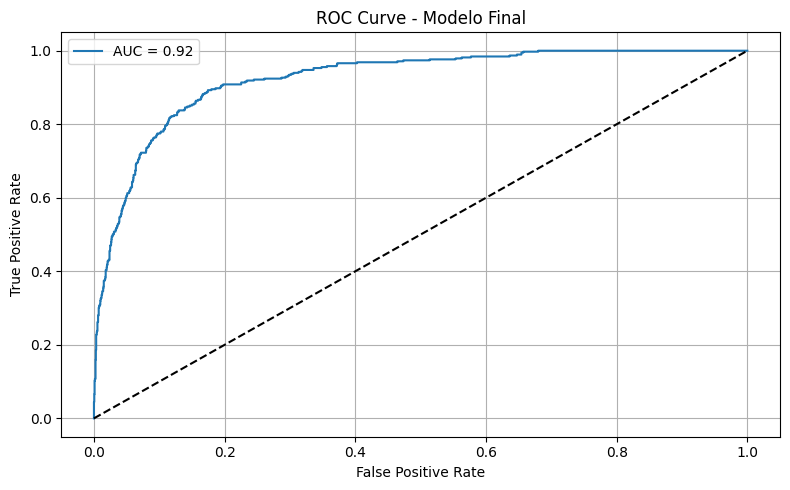

In [12]:
# === 11. Curva ROC ===
fpr, tpr, _ = roc_curve(y_test, y_test_proba)
plt.figure(figsize=(8, 5))
plt.plot(fpr, tpr, label=f"AUC = {roc_auc_score(y_test, y_test_proba):.2f}")
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve - Modelo Final")
plt.legend()
plt.grid()
plt.tight_layout()
plt.show()


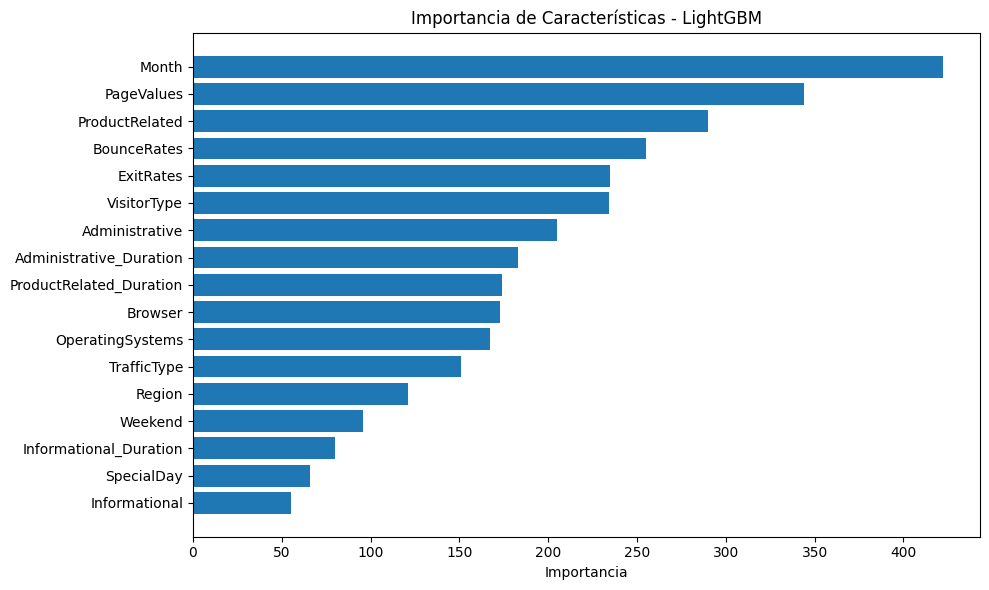

In [13]:
# === 12. Importancia de características ===
importances = final_model.feature_importances_
features = X.columns
importance_df = pd.DataFrame({"Feature": features, "Importance": importances})
importance_df = importance_df.sort_values(by="Importance", ascending=False)

plt.figure(figsize=(10, 6))
plt.barh(importance_df["Feature"], importance_df["Importance"])
plt.gca().invert_yaxis()
plt.xlabel("Importancia")
plt.title("Importancia de Características - LightGBM")
plt.tight_layout()
plt.show()